In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env

from result_visualization import show_results

from fastai.vision import (
    Learner, load_learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
learner = load_learner("/home/dmitri/Documents/model_weights/linknet34/", "linknet34_ops_full_e100_exp")

In [3]:
learner = learner.load("/home/dmitri/Documents/model_weights/linknet34/linknet34_student_ops_full_e100_wghts", )

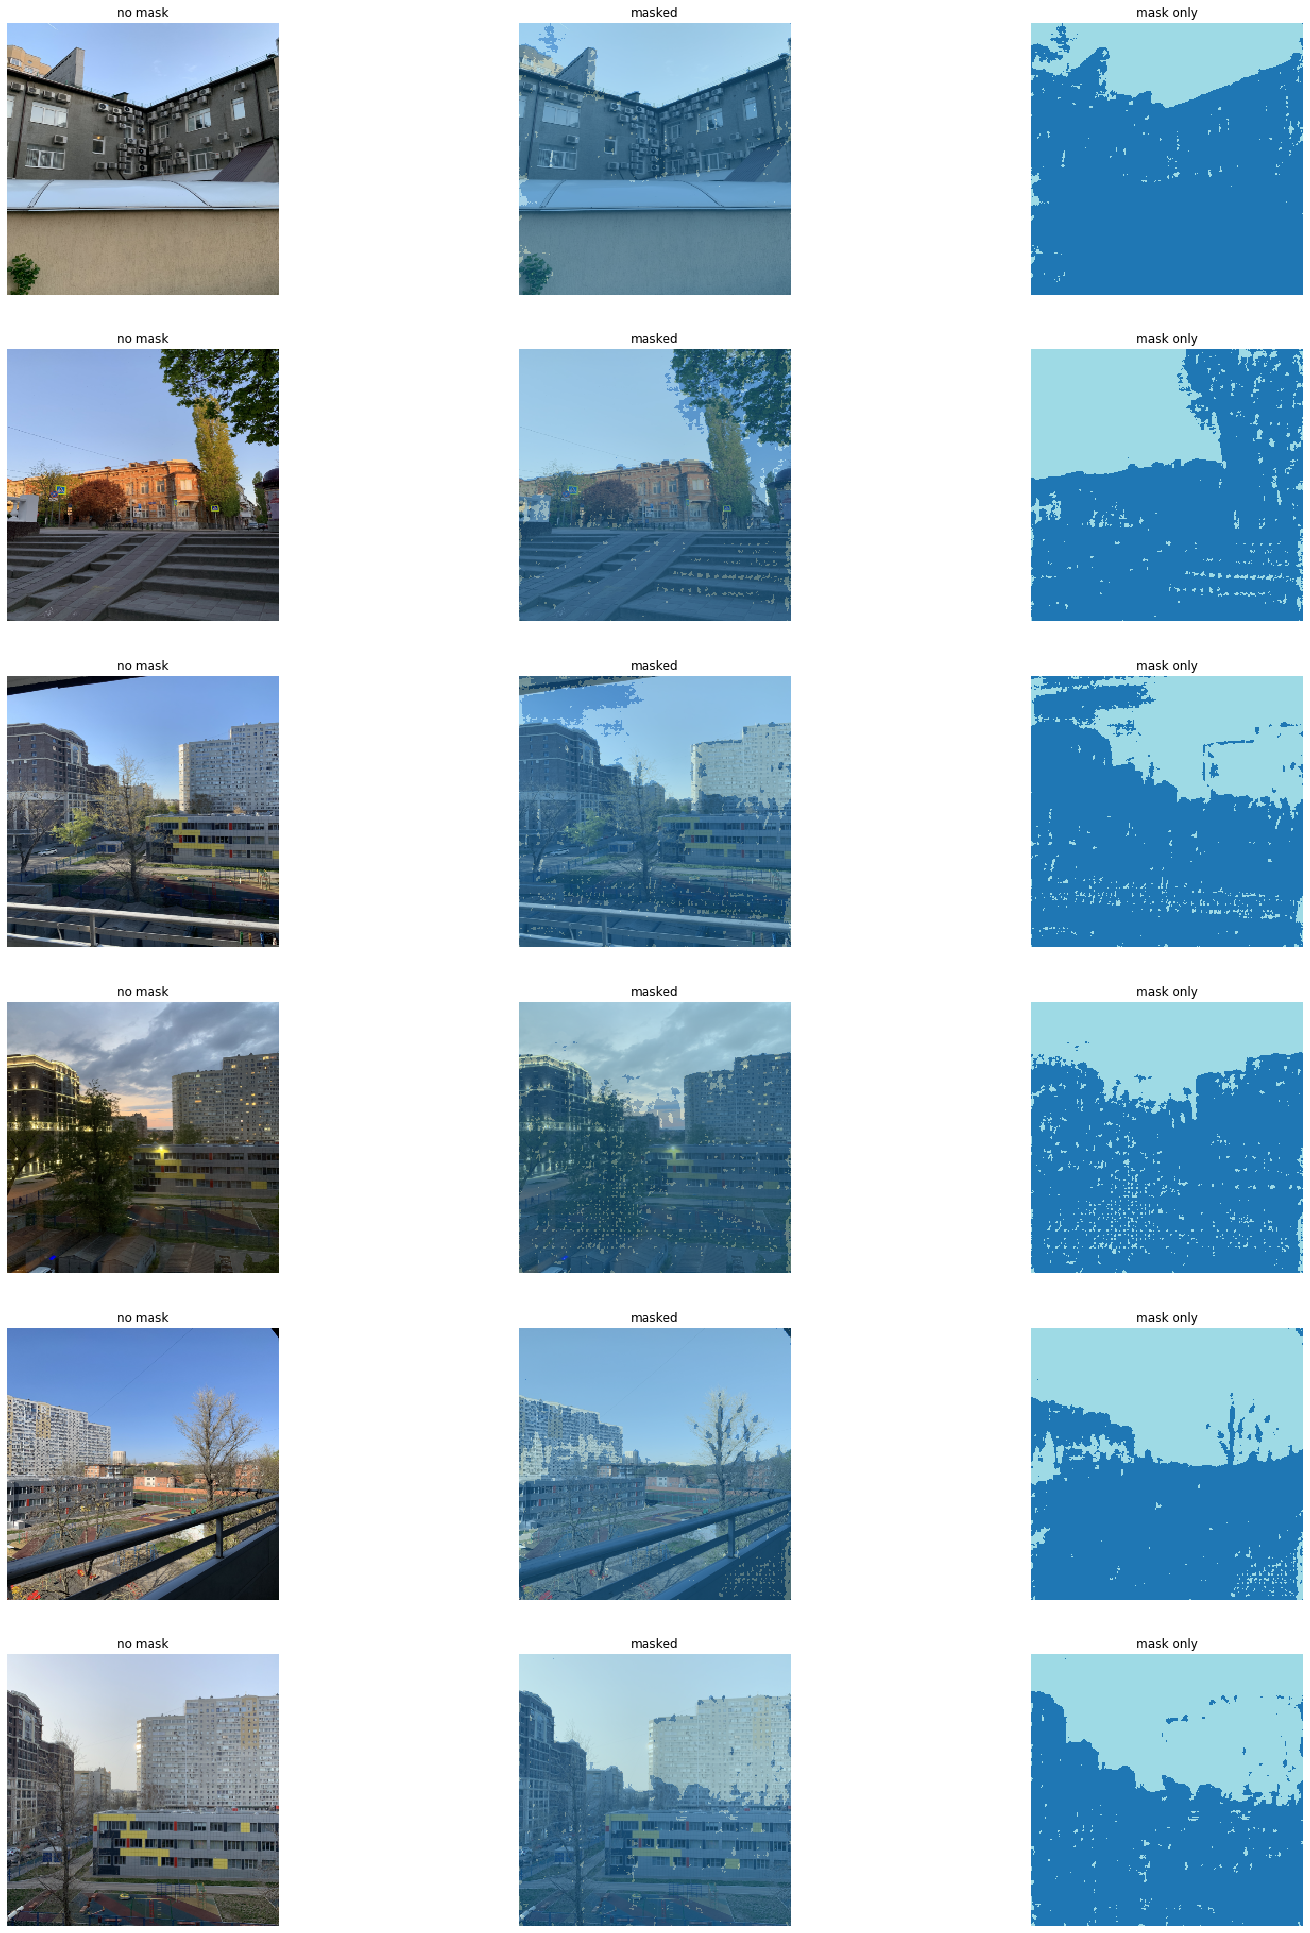

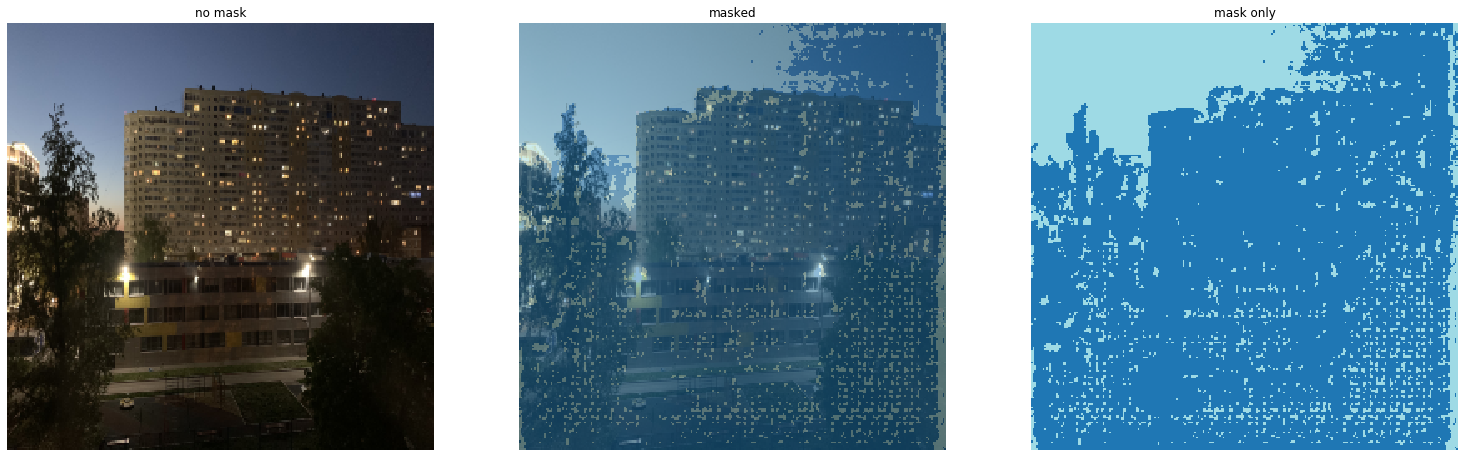

In [4]:
sizes= 256

test_data_vertical = (
    ImageListVertical
    .from_folder(data_env.get_subdir("transfer vertical"))
    .split_by_folder()
    .label_empty()
    .add_test_folder(test_folder="./")
    .transform(get_transforms(do_flip=False), size=sizes, resize_method=ResizeMethod.SQUISH)
    .databunch(bs=1)
    .normalize(imagenet_stats)
)

test_data = (
    ImageList
    .from_folder(data_env.get_subdir("transfer horizontal"))
    .split_by_folder()
    .label_empty()
    .add_test_folder(test_folder="./")
    .transform(get_transforms(do_flip=False), size=sizes, resize_method=ResizeMethod.SQUISH)
    .databunch(bs=1)
    .normalize(imagenet_stats)
)


show_results(test_data_vertical, learner)
show_results(test_data, learner)